# Deep Convolutional Variational Autoencoders- Codealong

## Introduction
Variational autoencoders (VAEs) can be used to visualize high-dimensional data in a meaningful, lower-dimensional space. In this lab, we will look at constructing and training a deep VAE on the MNIST data. We'll see how the data cluster in the lower-dimensional space according to their digit class. 

## Introduction
- Implement a variational autoencoder in Keras
- Define the deep convolutional networks for encoding and decoding functions in a VAE
- Generate new images and check for clustering as classes in the input distribution
- Perform sampling and tweaking in the latent space to generate images of all classes


## Variational Autoencodrs (VAEs)

VAEs don't learn to transform the data in and out of a compressed latent representation of itself like the 'vanilla' autoencoders we saw earlier. Instead, they learn the parameters of the probability distribution that the data came from. The encoder and decoder learn models that are in terms of underlying, unobserved *latent* variables. It's essentially an inference model and a generative model daisy-chained together.

![](https://i.imgur.com/ZN6MyTx.png)

VAEs are becoming popular because of their *generative* ability since they learn about the distribution the inputs came from, we can sample from that distribution to generate novel data. 
As we'll see, VAEs can also be used to cluster data in useful ways.

## Data preparation
Let's first import the necessary libraries into python environment

In [1]:
# Keras
import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   
K.clear_session()

# Data Processing
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import norm

# Printing models in ipynb
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG

# Set a seed to control randomization
np.random.seed(237)

Using TensorFlow backend.


We have the MNIST dataset available as test and train csv files in the local repo. Let's import these as our original (raw) datasets and check the contents of data. 

```python
# Read in the training and test datasets
train_raw= pd.read_csv('train.csv')
test_raw= pd.read_csv('test.csv')

train_raw.head()
```

In [2]:
# Read in the training and test datasets
train_raw= pd.read_csv('train.csv')
test_raw= pd.read_csv('test.csv')

train_raw.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


```python
test_raw.head()
```

In [3]:
# Code here 

Let's add a new column `label`to the test dataset. We'll give all the test images a label of '11' for now in order to later differentiate these from the images found in our training data set. Our training data contains labels to show the class of an image as we can see above. 

```python
# create 'label' column in test dataset; rearrange so that columns are in the same order as in train
test_raw['label'] = 11
test_columns = test_raw.columns.tolist()
test_columns = test_columns[-1:] + test_columns[:-1]
test_raw = test_raw[test_columns]
test_raw.head()
```

In [4]:
# create 'label' column in test dataset; rearrange so that columns are in the same order as in train
test_raw['label'] = 11
test_columns = test_raw.columns.tolist()
test_columns = test_columns[-1:] + test_columns[:-1]
test_raw = test_raw[test_columns]
test_raw.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Great. We now have as extra columns `label` in our test set showing `11` for all entries. We'll shortly see how this comes into play. 

We previously learned that for meaningful results, we need to train our architecture with as many images as possible. Also, since we don't need the labels for building the model in semi-supervised approach that we are following, we will combine the train and test data into a single dataframe, while ignoring the index of original data. 

```python
# combine original train and test sets
data = pd.concat([train_raw, test_raw], ignore_index = True)
data.head()
```

In [5]:
# combine original train and test sets
data = pd.concat([train_raw, test_raw], ignore_index = True)
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Split into Training & Validation sets

Just as we saw with our supervised learning models, the VAE algorithm needs to minimize a 'loss' function. 
For VAEs, the loss is actually a combination two different 'losses. 

- Loss describing the difference between the input images and the images reconstructed from samples from the latent distribution.
- Loss describing the difference between the latent distribution and the prior (the inputs).  This loss can be calculated on a validation set with each training epoch as an estimate of how the model describes data it was not trained on.  

Now that we have combined the original train and test data as `data`,  the new train and validation sets that we make below will each have some images with missing labels i.e. `11`.

```python
# Hold out 5000 random images as a validation/test sample
valid = data.sample(n = 5000, random_state = 99)
train = data.loc[~data.index.isin(valid.index)]

# free up some space and delete test and combined
del train_raw, test_raw, data

valid.head()
```

In [6]:
# Hold out 5000 random images as a validation/test sample
valid = data.sample(n = 5000, random_state = 99)
train = data.loc[~data.index.isin(valid.index)]

# free up some space and delete test and combined
del train_raw, test_raw, data

valid.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
5406,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53858,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30647,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36944,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24742,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Excellent, we now have our created training and validation sets that we can move forward with. But first, we need to apply some more pre-processing to this data in order to get it ready for our VAE. 

## Reshape & Normalize the Data

We will build our encoder and decoder models and deep convolutional neural networks in keras, similar to what we saw in convolution AE. We first need to perform following tasks:

- Separate the input features from the target labels 
- Normalize input features by dividing the max pixel value 
- Reshape features into 28x28 pixel images.

```python
# Create features for training and validation sets 
X_train = train.drop(['label'], axis = 1)
X_valid = valid.drop(['label'], axis = 1)

# Create labels for training and validation sets 
y_train = train['label']
y_valid = valid['label']

# Normalize the data by dividing with max pixel value i.e. 255
X_train = X_train.astype('float32') / 255.
X_valid = X_valid.astype('float32') / 255.

# Reshape the images as 2D array of 28x28 pixels
X_train = X_train.values.reshape(-1,28,28,1)
X_valid = X_valid.values.reshape(-1,28,28,1)
```

In [7]:
# Create features for training and validation sets 
X_train = train.drop(['label'], axis = 1)
X_valid = valid.drop(['label'], axis = 1)

# Create labels for training and validation sets 
y_train = train['label']
y_valid = valid['label']

# Normalize the data by dividing with max pixel value i.e. 255
X_train = X_train.astype('float32') / 255.
X_valid = X_valid.astype('float32') / 255.

# Reshape the images as 2D array of 28x28 pixels
X_train = X_train.values.reshape(-1,28,28,1)
X_valid = X_valid.values.reshape(-1,28,28,1)

Let's take a look at a few random images in our dataset.

```python
plt.figure(1, figsize=(10,10))
plt.subplot(321)
plt.imshow(X_train[15][:,:,0])

plt.subplot(322)
plt.imshow(X_train[680][:,:,0])

plt.subplot(323)
plt.imshow(X_train[2325][:,:,0])

plt.subplot(324)
plt.imshow(X_train[42073][:,:,0])
plt.show()
```

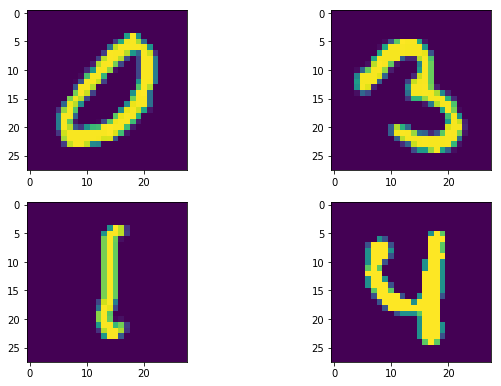

In [8]:
plt.figure(1, figsize=(10,10))
plt.subplot(321)
plt.imshow(X_train[15][:,:,0])

plt.subplot(322)
plt.imshow(X_train[680][:,:,0])

plt.subplot(323)
plt.imshow(X_train[2325][:,:,0])

plt.subplot(324)
plt.imshow(X_train[42073][:,:,0])
plt.show()

Our pre-processing stage did its job. We now have our images as 28x28 pixel array, ready to be fed into convolutional architectures. Let's start building our model. 

## Model construction

Let's define some parameters for the training process based on pre-processed MNIST dataset, batch size for processing images and also define a latent dimension with two parameters i.e. mean and sigma. 

```python
# Define model parameters
img_shape = (28, 28, 1)    # for MNIST
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters
```

In [9]:
# Define model parameters
img_shape = (28, 28, 1)    # for MNIST
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

### Encoder Model

Following the diagram in the introduction, we can see that a VAE has three basic parts:  

1. An encoder that to learn the parameters (mean and variance) of the underlying latent distribution  
2. Some means of sampling from that distribution
3. A decoder model that can turn the sample from 2 above, back to an image.  

We will use deep convolutional nets for both encoding and decoding stages. We will build the encoder with two output layers, one for the latent distribution mean (z_mu) and the other for its variance (z_log_sigma).

#### `Encoder architecture: Input -> Conv2D x 4 -> Flatten ->  Dense`

```python
# Build the encoder network 

# The input layer
input_img = keras.Input(shape=img_shape)

# 2d Convolutional layers
x = layers.Conv2D(32, 3,padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3,padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,padding='same', activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_original = K.int_shape(x)

# Flatten 
x = layers.Flatten()(x)

# Add a dense layer 
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)
```

In [10]:
# Build the encoder network 

# The input layer
input_img = keras.Input(shape=img_shape)

# 2d Convolutional layers
x = layers.Conv2D(32, 3,padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3,padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,padding='same', activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_original = K.int_shape(x)

# Flatten 
x = layers.Flatten()(x)

# Add a dense layer 
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

We can view our encoder architecture as below:

```python
# View the encoder
encoder_model = Model(input_img, x)
SVG(model_to_dot(encoder_model, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))
```

In [14]:
#!pip install pydot

smart-open 1.8.0 requires bz2file, which is not installed.
pexpect 4.6.0 requires ptyprocess>=0.5, which is not installed.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


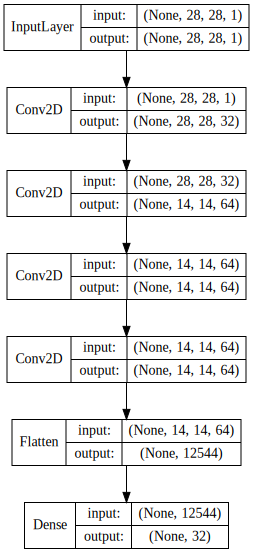

In [11]:
# View the encoder
encoder_model = Model(input_img, x)
SVG(model_to_dot(encoder_model, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

### Sampling Function


We will now create a function to sample from the distribution we just learned the parameters of. We wil define `epsilon` is a tensor of small random normal values, following the assumption that our data comes from a random process and is normally distributed in the latent space. With Keras, everything has to be in a 'layer' to compile correctly. This goes for our sampling function. The `Lambda` layer wrapper let's us do this.

```python
# Define sampling function to sample from distribution defined by z_mu and z_log_sigma

def sampling(args):
    z_mu, z_log_sigma = args
    
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])
```

In [12]:
# Define sampling function to sample from distribution defined by z_mu and z_log_sigma

def sampling(args):
    z_mu, z_log_sigma = args

    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)

    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

### Decoder Model

Finally, we will build a decoder that will perform a function exactly opposite to that of an encoder. We will use `Conv2DTranspose` to achieve this. 

```python
# Decoder takes its input from the samples taken from the latent distribution
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand the input to 784 (28*28) total pixels
x = layers.Dense(np.prod(shape_original[1:]),activation='relu')(decoder_input)

# rReshape the data
x = layers.Reshape(shape_original[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)
```

In [13]:
# Decoder takes its input from the samples taken from the latent distribution
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand the input to 784 (28*28) total pixels
x = layers.Dense(np.prod(shape_original[1:]),activation='relu')(decoder_input)

# rReshape the data
x = layers.Reshape(shape_original[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

Let's see what our decoder looks like:

```python
# View the decoder
SVG(model_to_dot(decoder, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))
```

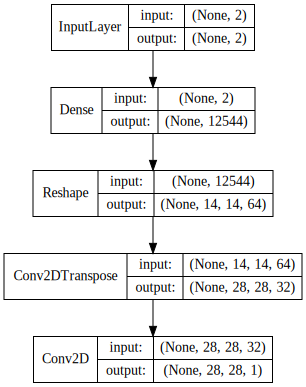

In [14]:
# View the decoder
SVG(model_to_dot(decoder, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

## Loss Function

We identified earlier that VAE is trained using a loss function with two components:  

1. **Reconstruction loss**: This is the cross-entropy describing the errors between the decoded samples from the latent distribution and the original inputs.  
2. **The Kullback-Liebler (KL) Divergence**: Divergence between the latent distribution and the prior (this acts as a regularization term).  

Let's define a final custom layer class `CustomVariationalLayer` that calculates the loss as shown below. 

```python
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
       
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])
```

In [15]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)

        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)

        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):

        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)

        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

Now we can instantiate the model and take a look at its summary.

```python
# VAE model statement
VAE = Model(input_img, y)
VAE.compile(optimizer='rmsprop', loss=None)

# View the model summary
VAE.summary()
```

In [16]:
# VAE model statement
VAE = Model(input_img, y)
VAE.compile(optimizer='rmsprop', loss=None)

# View the model summary
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

As earlier, we can optionally choose to view the final graph of our model to see how these layers are connected together. 

```python
## The Final VAE 
SVG(model_to_dot(VAE, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))
```

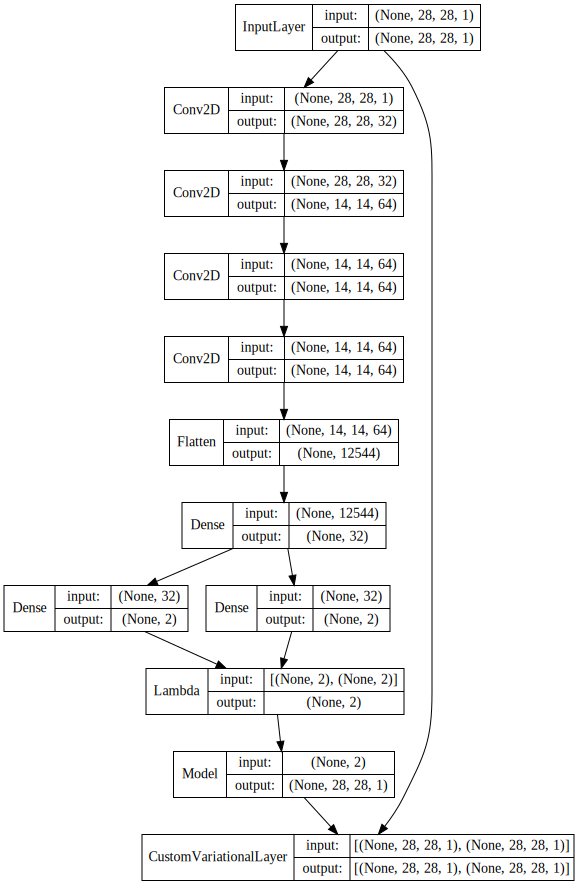

In [17]:
## The Final VAE 
SVG(model_to_dot(VAE, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Great, we have successully built our model as seen in the graph above. We can now feed MNIST data into this model and train it to generate MNIST-like images. 

## Train the VAE
Finally, we fit the model with out training dataset and validate using the validation data we created earlier.

```python
# Fit the model 
VAE.fit(x=X_train, y=None,
        shuffle=True,
        epochs=5,
        batch_size=batch_size,
        validation_data=(X_valid, None))
```

In [19]:
# Fit the model 
VAE.fit(x=X_train, y=None,
        shuffle=True,
        epochs=2, # Should be higher, but reduced in the interests of time
        batch_size=batch_size,
        validation_data=(X_valid, None))

Train on 65000 samples, validate on 5000 samples
Epoch 1/2
64992/65000 [============================>.] - ETA: 0s - loss: 0.2065

KeyboardInterrupt: 

## Prediction and Clustering of digits in the latent space

To understand the implications of a variational autoencoder model and how it differs from standard autoencoder architectures, it's useful to examine the latent space. We can make predictions on the validation set using our encoder network. This enables us to translate the images from the 784-dimensional input space into the 2-dimensional latent space. 

We will color-code translated data points according to their known digit class to see how the digits cluster together.

```python
# Isolate original training set records in validation set
valid_no_test = valid[valid['label'] != 11]

# Create X and Y
X_valid_no_test = valid_no_test.drop('label', axis=1)
y_valid_no_test = valid_no_test['label']

# Reshape and normalize as earlier
X_valid_no_test = X_valid_no_test.astype('float32') / 255.
X_valid_no_test = X_valid_no_test.values.reshape(-1,28,28,1)
```

In [ ]:
# Isolate original training set records in validation set
valid_no_test = valid[valid['label'] != 11]

# Create X and Y
X_valid_no_test = valid_no_test.drop('label', axis=1)
y_valid_no_test = valid_no_test['label']

# Reshape and normalize as earlier
X_valid_no_test = X_valid_no_test.astype('float32') / 255.
X_valid_no_test = X_valid_no_test.values.reshape(-1,28,28,1)

```python
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_no_test_encoded = encoder.predict(X_valid_no_test, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_no_test_encoded[:, 0], x_valid_no_test_encoded[:, 1], c=y_valid_no_test, cmap='brg')
plt.colorbar()
plt.show()
```

In [ ]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_no_test_encoded = encoder.predict(X_valid_no_test, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_no_test_encoded[:, 0], x_valid_no_test_encoded[:, 1], c=y_valid_no_test, cmap='brg')
plt.colorbar()
plt.show()

Above is the equilibrium reached by the cluster-forming nature of the reconstruction loss, and the dense packing nature of the KL loss, forming distinct clusters the decoder can decode. This is great, as it means when randomly generating, if we sample a vector from the same prior distribution of the encoded vectors, $N(0, I)$, the decoder will successfully decode it. And if we are interpolating, there are no sudden gaps between clusters, but a smooth mix of features a decoder can understand.

Let's also Include the original test set data lets us see where they fall with respect to the known digit clusters.

```python
# set colormap so that 11's are gray
custom_cmap = matplotlib.cm.get_cmap('brg')
custom_cmap.set_over('gray')

x_valid_encoded = encoder.predict(X_valid, batch_size=batch_size)
plt.figure(figsize=(10, 10))
gray_marker = mpatches.Circle(4,radius=0.1,color='gray', label='Test')
plt.legend(handles=[gray_marker], loc = 'best')
plt.scatter(x_valid_encoded[:, 0], x_valid_encoded[:, 1], c=y_valid, cmap=custom_cmap)
plt.clim(0, 9)
plt.colorbar()
```

In [ ]:
# set colormap so that 11's are gray
custom_cmap = matplotlib.cm.get_cmap('brg')
custom_cmap.set_over('gray')

x_valid_encoded = encoder.predict(X_valid, batch_size=batch_size)
plt.figure(figsize=(10, 10))
gray_marker = mpatches.Circle(4,radius=0.1,color='gray', label='Test')
plt.legend(handles=[gray_marker], loc = 'best')
plt.scatter(x_valid_encoded[:, 0], x_valid_encoded[:, 1], c=y_valid, cmap=custom_cmap)
plt.clim(0, 9)
plt.colorbar()

We can see the grey dots lie within the same space i.e the latent distribution is well in line with our prior.

## Sampling digits

Another application of this architecture is to use the decoder network to look at **what samples from the latent space look like as we change the latent variables**. We will construct a grid for varying latent variable values and for each location in the grid, we will decode the latent variables and print the generated image.

By sampling from the latent space, we can use the decoder network to form a generative model capable of creating new data similar to what was observed during training. Specifically, we'll sample from the prior distribution  which we assumed follows a unit Gaussian distribution. Here, we've sampled a grid of values from a two-dimensional Gaussian and displayed the output of our decoder network


```python
# Display a 2D manifold of the digits
n = 40  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

# Plot the final grid
plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  
```

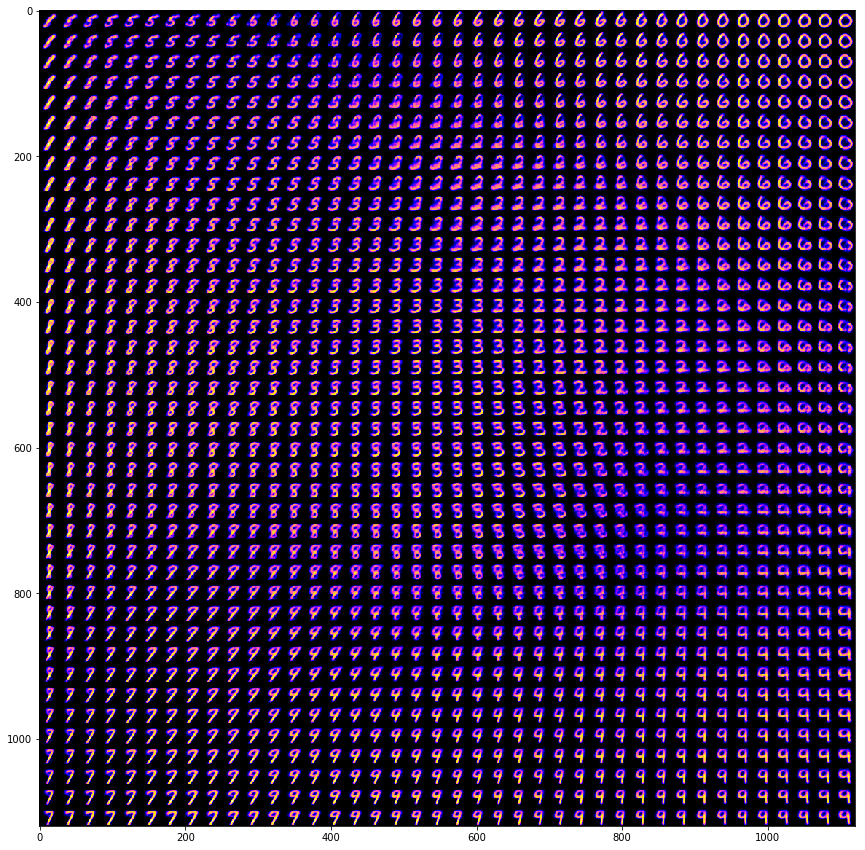

In [31]:
# Display a 2D manifold of the digits
n = 40  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

# Plot the final grid
plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  

What we end up with is a smoothly varying space where each digit transforms into the others as we dial the latent variables up and down. As you can see, the distinct digits each exist in different regions of the latent space and smoothly transform from one digit to another.

## Further Reading

Visit following links, search for similar experiments to see how VAEs can produce amazing results when trained on large amounts of data and how we can use these to model real world phenomena. 


[MUSIC-VAE: Google builds a model for interpolating between two music samples](https://magenta.tensorflow.org/music-vae) - This is amazing

[Variational Autoencoders for Grammar and Text](https://www.youtube.com/watch?v=ar4Fm1V65Fw)

## Summary 

In this lab, we looked at developing a convolutional VAE for generating MNIST-like images with a very brief and simple training phase. VAEs really shine when used with high dimensional datasets. You are encouraged to look at some real experiments following VAE approach and how these have become state of the art of generating images, music and text.